<h1>ПГК Оракул / Прогнозирование спроса на грузовые ЖД перевозки<span class="tocSkip"></span></h1>

<h3>Описание проблемы<span class="tocSkip"></span></h3>

Объём парка Первой грузовой компании составляет около 100 тыс. вагонов. Если порожние вагоны простаивают или их по каким-либо причинам приходится перегонять, компания теряет существенную часть прибыли.

Таким образом, прогнозирование спроса на грузовые ЖД перевозки является необходимым этапом для эффективного распределения ресурсов компании.

Для решения задачи командам будет предоставлена часть объемов перевозок ПГК со стабильными, сезонными и редкими направлениями. Их необходимо будет учесть при создании модели.

<h3>Ограничение на технологии<span class="tocSkip"></span></h3>

- Язык: Python
- Использовать библиотеки с открытым доступом

<h3>Данные<span class="tocSkip"></span></h3>

1. **ct_train_test.csv**


CSV с объемами перевозок ПГК (месяц, тонны, вагоноотправки, род подвижного состава и т.д.)

2. **station_mapping.csv | freight_mapping.csv | client_mapping.csv**


Справочники

3. **forecast_example.csv**


Пример результата

4. **Hackathon - baseline and metric scripts.ipynb**


- Методология оценки KPI (функция python).
- Baseline для быстрого старта


5. **Описание данных для хакатона - прогноз ЖД перевозок**


Описание данных

<h3>Задача<span class="tocSkip"></span></h3>

Разработать ML-модель для прогнозирования спроса на грузовые железнодорожные перевозки

## Разведывательный анализ данных

### Импорт данных

Импортируем необходимые для работы библиотеки. Считаем данные из csv-файлов в датафреймы, сохраним в переменные и выведем на экран каждую таблицу.

In [1]:
# data analysis
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    cross_val_score,
    TimeSeriesSplit
)

from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge
)

from category_encoders import MEstimateEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from statsmodels.tsa.seasonal import seasonal_decompose
from ydata_profiling import ProfileReport
from collections import Counter

# pandas option
pd.set_option('display.max_columns', None)

In [2]:
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.special import inv_boxcox

# праздники для профета
import holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2018,2019,2020,2021,2022,2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "RUS-Holidays"}, index=[0])], axis=0)
holiday

,ds,holiday
0,2018-01-01,RUS-Holidays
0,2018-01-02,RUS-Holidays
0,2018-01-03,RUS-Holidays
0,2018-01-04,RUS-Holidays
0,2018-01-05,RUS-Holidays
...,...,...
0,2023-05-01,RUS-Holidays
0,2023-05-08,RUS-Holidays
0,2023-05-09,RUS-Holidays
0,2023-06-12,RUS-Holidays


In [3]:
try:
    full_df = pd.read_csv('fact_train_test.csv', sep=";", decimal=",", encoding="windows-1251")
except:
    print('Датасет отсутствует')

# конвертация во временной тип
full_df["period"] = full_df["period"].astype("datetime64[ns]")

full_df.head()

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1


Данные подгрузились нормально.

### Описание данных

In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559232 entries, 0 to 3559231
Data columns (total 11 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   period                  datetime64[ns]
 1   rps                     int64         
 2   podrod                  int64         
 3   filial                  int64         
 4   client_sap_id           int64         
 5   freight_id              int64         
 6   sender_station_id       int64         
 7   recipient_station_id    int64         
 8   sender_organisation_id  int64         
 9   real_weight             float64       
 10  real_wagon_count        int64         
dtypes: datetime64[ns](1), float64(1), int64(9)
memory usage: 298.7 MB


In [5]:
full_df.describe().T

,count,mean,min,25%,50%,75%,max,std
period,3559232,2020-01-01 04:50:29.038176256,2012-07-01 00:00:00,2018-06-01 00:00:00,2020-01-01 00:00:00,2021-08-01 00:00:00,2023-03-01 00:00:00,NaN
rps,3559232.0,0.597964,0.0,0.0,1.0,1.0,1.0,0.490309
podrod,3559232.0,3.338106,0.0,2.0,5.0,5.0,9.0,1.964952
filial,3559232.0,1.148843,0.0,1.0,1.0,1.0,2.0,0.530539
client_sap_id,3559232.0,386.568522,-1.0,-1.0,108.0,601.0,2417.0,539.87277
freight_id,3559232.0,1712.424234,0.0,1059.0,1622.0,2219.0,5086.0,1029.590646
sender_station_id,3559232.0,26281.220263,0.0,14272.0,30519.0,35196.0,39123.0,11109.796436
recipient_station_id,3559232.0,25981.680081,0.0,13731.0,30790.0,35196.0,39123.0,11461.031719
sender_organisation_id,3559232.0,14996.810303,0.0,7856.0,12026.0,22011.0,34536.0,8048.006401
real_weight,3559232.0,1349.654063,-6.0,65.0,130.0,399.0,820435.0,9062.865634


In [6]:
cat_f = ['podrod', 'rps', 'filial', 'client_sap_id', 'freight_id',
       'sender_station_id', 'recipient_station_id', 'sender_organisation_id']

for i in cat_f:
    full_df[i] = full_df[i].astype(str)

In [7]:
# удаление странных значений
full_df = full_df.query('~(real_wagon_count == 0 and real_weight > 100)')

In [8]:
full_df['capacity'] = full_df['real_weight']/full_df['real_wagon_count']
full_df = full_df.query('~(capacity > 100 and real_wagon_count > 0)')
full_df.drop('capacity', axis=1, inplace=True)
full_df.shape

(3536572, 11)

### Обработка данных и генерация признаков

#### Пропуски и дубликаты

Проверим, монотонны ли временные данные.

In [9]:
full_df['ds'] = full_df['period']
full_df.set_index('ds', inplace = True)
full_df.index.is_monotonic_increasing

True

In [10]:
# проверка явных дубликатов
full_df.duplicated().sum()

0

In [11]:
# проверка пропусков
full_df.isna().sum()

period                    0
rps                       0
podrod                    0
filial                    0
client_sap_id             0
freight_id                0
sender_station_id         0
recipient_station_id      0
sender_organisation_id    0
real_weight               0
real_wagon_count          0
dtype: int64

#### Client ID

In [12]:
# создаем таблицу по месяцам, где списку клиентов соответствует список
'''
создаем таблицу по месяцам, rps и client_sap_pd, где списку клиентов соответствует список
частот перевозок и суммарное количество вагонов
'''
clients = full_df.groupby(
    ['period', 'rps', 'client_sap_id'])\
    .aggregate({'real_weight':'count', 'real_wagon_count':'sum'}).reset_index()
clients = clients.groupby(['period', 'rps']).agg(list)
clients.rename(columns={'real_weight':'count', 'real_wagon_count':'sum'}, inplace=True)
clients.tail(10)

client_sap_id  \
period     rps                                                      
2022-11-01 0    [-1, 0, 1, 100, 1002, 1006, 101, 1013, 1018, 1...   
           1    [-1, 10, 1036, 1053, 1054, 1056, 1058, 106, 10...   
2022-12-01 0    [-1, 0, 1, 100, 1002, 1006, 101, 1013, 1017, 1...   
           1    [-1, 10, 1002, 1053, 1054, 1056, 1058, 106, 10...   
2023-01-01 0    [-1, 0, 1, 100, 1002, 1006, 101, 1013, 1018, 1...   
           1    [-1, 10, 1053, 1054, 1056, 1058, 106, 107, 107...   
2023-02-01 0    [-1, 0, 1, 100, 1000, 1002, 1006, 101, 1013, 1...   
           1    [-1, 10, 1036, 1053, 1054, 1056, 1058, 106, 10...   
2023-03-01 0    [-1, 0, 1, 100, 1000, 1002, 1006, 101, 1013, 1...   
           1    [-1, 10, 1053, 1054, 1056, 1058, 106, 107, 107...   

                                                            count  \
period     rps                                                      
2022-11-01 0    [4807, 12, 48, 12, 289, 48, 11, 20, 32, 35, 24...   
           1    [7922, 20, 12, 93, 611, 20, 13, 162, 5, 4, 7, ...   
2022-12-01 0    [4665, 6, 68, 13, 196, 44, 18, 32, 1, 13, 31, ...   
           1    [8148, 10, 1, 174, 504, 23, 16, 172, 13, 4, 3,...   
2023-01-01 0    [3989, 7, 46, 13, 44, 44, 14, 30, 9, 14, 16, 4...   
           1    [7268, 14, 209, 495, 16, 13, 185, 11, 4, 3, 5,...   
2023-02-01 0    [4400, 11, 26, 13, 5, 206, 32, 15, 44, 1, 47, ...   
           1    [8244, 6, 2, 243, 583, 14, 7, 175, 6, 4, 5, 5,...   
2023-03-01 0    [5282, 10, 43, 10, 3, 207, 43, 12, 16, 2, 95, ...   
           1    [9040, 7, 322, 660, 8, 15, 175, 8, 2, 10, 34, ...   

                                                              sum  
period     rps                                                     
2022-11-01 0    [8525, 17, 86, 19, 126, 143, 12, 33, 106, 31, ...  
           1    [161306, 1704, 16, 1180, 37352, 342, 228, 1194...  
2022-12-01 0    [8961, 12, 101, 22, 87, 131, 21, 101, 1, 59, 3...  
           1    [162970, 1622, 2, 1718, 35401, 650, 313, 1069,...  
2023-01-01 0    [7232, 17, 73, 17, 44, 93, 16, 84, 35, 22, 20,...  
           1    [155898, 1556, 2098, 37572, 533, 275, 1335, 23...  
2023-02-01 0    [7795, 33, 80, 19, 5, 26, 99, 15, 75, 1, 78, 2...  
           1    [157670, 441, 18, 1967, 41608, 475, 42, 1036, ...  
2023-03-01 0    [9624, 17, 76, 15, 10, 20, 95, 13, 47, 2, 324,...  
           1    [177995, 1800, 1949, 42697, 311, 208, 973, 21,...

In [13]:
'''
создаем два датафрейма, один для частот, второй для суммы вагонов
по клиентам
'''

freq = pd.DataFrame()
wagons = pd.DataFrame()

n = 96

# берем последние n месяцев,
# сначала для rps = 0
for i in range(-n, 0, 2):   
    freq = pd.merge(
        left=freq,
        right=pd.DataFrame(
            data=clients['count'][i], columns=[i], index=clients['client_sap_id'][i]),
        left_index=True,
        right_index=True,
        how='outer')
    wagons = pd.merge(
        left=wagons,
        right=pd.DataFrame(
            data=clients['sum'][i], columns=[i], index=clients['client_sap_id'][i]),
        left_index=True,
        right_index=True,
        how='outer')

# NaN заполняем нулями    
freq.fillna(0, inplace=True)
wagons.fillna(0, inplace=True)

freq.head(10)

,-96,-94,-92,-90,-88,-86,-84,-82,-80,-78,-76,-74,-72,-70,-68,-66,-64,-62,-60,-58,-56,-54,-52,-50,-48,-46,-44,-42,-40,-38,-36,-34,-32,-30,-28,-26,-24,-22,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2
-1,8338.0,8223.0,8123.0,8191.0,7884.0,7784.0,7661.0,7067.0,6712.0,5468.0,6599.0,7207.0,7427.0,6892.0,7004.0,6653.0,6522.0,6740.0,6733.0,5890.0,6426.0,4879.0,5820.0,6648.0,7082.0,6163.0,6260.0,6237.0,6342.0,5749.0,4526.0,5225.0,5147.0,4093.0,4768.0,5762.0,5813.0,4907.0,4690.0,4524.0,4815.0,4938.0,4818.0,4807.0,4665.0,3989.0,4400.0,5282.0
0,8.0,5.0,6.0,3.0,4.0,4.0,4.0,4.0,5.0,5.0,2.0,4.0,2.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,11.0,7.0,7.0,6.0,7.0,6.0,8.0,8.0,6.0,7.0,7.0,7.0,7.0,7.0,8.0,6.0,5.0,7.0,6.0,5.0,12.0,6.0,7.0,11.0,10.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0,12.0,30.0,22.0,16.0,24.0,30.0,12.0,3.0,25.0,25.0,39.0,33.0,35.0,63.0,49.0,11.0,27.0,45.0,40.0,56.0,48.0,68.0,46.0,26.0,43.0
100,10.0,9.0,11.0,14.0,14.0,9.0,15.0,13.0,15.0,13.0,11.0,10.0,11.0,11.0,9.0,7.0,12.0,18.0,11.0,15.0,17.0,9.0,14.0,14.0,14.0,11.0,19.0,13.0,19.0,18.0,18.0,20.0,14.0,13.0,15.0,16.0,5.0,10.0,18.0,10.0,11.0,18.0,13.0,12.0,13.0,13.0,13.0,10.0
1000,0.0,2.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,3.0
1001,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,12.0,0.0,8.0,9.0,0.0,0.0,6.0,11.0,11.0,4.0,20.0,23.0,56.0,61.0,32.0,30.0,30.0,37.0,31.0,100.0,66.0,27.0,49.0,47.0,368.0,303.0,289.0,196.0,44.0,206.0,207.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,60.0,65.0,56.0,47.0,61.0,65.0,59.0,49.0,71.0,78.0,83.0,61.0,54.0,70.0,50.0,54.0,62.0,57.0,58.0,61.0,67.0,85.0,65.0,41.0,48.0,44.0,44.0,32.0,43.0


In [14]:
wagons.head(10)

,-96,-94,-92,-90,-88,-86,-84,-82,-80,-78,-76,-74,-72,-70,-68,-66,-64,-62,-60,-58,-56,-54,-52,-50,-48,-46,-44,-42,-40,-38,-36,-34,-32,-30,-28,-26,-24,-22,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2
-1,16836.0,16014.0,15662.0,15903.0,15155.0,14581.0,15115.0,13579.0,13012.0,10827.0,12487.0,13526.0,11955.0,11159.0,11662.0,11471.0,10865.0,11191.0,11881.0,10063.0,10306.0,7919.0,9526.0,11319.0,12085.0,11458.0,11204.0,10916.0,10908.0,10309.0,9105.0,9067.0,10048.0,7327.0,8082.0,9872.0,10312.0,8751.0,8167.0,7916.0,8133.0,7953.0,8690.0,8525.0,8961.0,7232.0,7795.0,9624.0
0,16.0,10.0,21.0,6.0,10.0,22.0,20.0,8.0,10.0,8.0,5.0,13.0,8.0,23.0,13.0,14.0,11.0,8.0,14.0,16.0,22.0,13.0,20.0,33.0,18.0,14.0,25.0,21.0,14.0,22.0,15.0,12.0,26.0,22.0,49.0,25.0,32.0,23.0,23.0,21.0,11.0,18.0,14.0,17.0,12.0,17.0,33.0,17.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,14.0,39.0,28.0,28.0,29.0,40.0,15.0,3.0,70.0,34.0,57.0,57.0,79.0,107.0,79.0,19.0,43.0,82.0,67.0,82.0,86.0,101.0,73.0,80.0,76.0
100,16.0,14.0,14.0,23.0,20.0,11.0,20.0,18.0,24.0,17.0,17.0,15.0,22.0,16.0,16.0,12.0,17.0,26.0,15.0,24.0,26.0,10.0,19.0,23.0,20.0,18.0,30.0,15.0,22.0,21.0,21.0,28.0,19.0,18.0,21.0,21.0,5.0,14.0,21.0,13.0,14.0,25.0,15.0,19.0,22.0,17.0,19.0,15.0
1000,0.0,2.0,0.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,10.0
1001,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,16.0,16.0,16.0,5.0,56.0,80.0,75.0,104.0,104.0,79.0,76.0,72.0,55.0,215.0,181.0,41.0,124.0,142.0,214.0,152.0,126.0,87.0,44.0,26.0,20.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,104.0,120.0,94.0,79.0,97.0,90.0,93.0,92.0,115.0,134.0,126.0,95.0,90.0,98.0,84.0,90.0,133.0,121.0,106.0,120.0,123.0,163.0,114.0,80.0,143.0,131.0,93.0,99.0,95.0


Получились матрицы для всех клиентов, кто перевозил что-то за последние n месяцев. Отберем те id, кто был активен последние шесть месяцев.

In [15]:
# суммируем последние 6 месяцев
wagons['sum'] = wagons.iloc[:, -6:].sum(axis=1)

# удаляем те id, кто ничего не возил
wagons = wagons[wagons['sum'] > 0]
wagons.drop('sum', axis=1, inplace=True)

# записываем названия колонок и удаляем id из таблицы частот
freq.columns = clients[-n::2].index.droplevel(1)
freq = freq[freq.index.isin(wagons.index)]

freq.shape

(783, 48)

 Попробуем спрогнозировать количество перевозок по каждому client_sap_id на пять месяцев вперед.


In [16]:
# создаем временную таблицу для профета
temp = full_df.groupby('period').agg('first')['rps'].reset_index()
temp.columns = ['ds', 'y']

# инициируем профета и создаем будущее
model = Prophet()
model.fit(temp)
future = model.make_future_dataframe(
    periods=5, freq='MS').iloc[-12:]
future

02:17:56 - cmdstanpy - INFO - Chain [1] start processing
02:17:56 - cmdstanpy - INFO - Chain [1] done processing


,ds
78,2022-09-01
79,2022-10-01
80,2022-11-01
81,2022-12-01
82,2023-01-01
83,2023-02-01
84,2023-03-01
85,2023-04-01
86,2023-05-01
87,2023-06-01


In [17]:
#датафрейм, в котором будут client_id с rps 0
clients_rps_0 = pd.DataFrame()

for i in range(len(freq)):
    model = Prophet(
        holidays=holiday,
        changepoint_prior_scale=0.5)
    
    temp = pd.DataFrame({'y': freq.iloc[i].values, 'ds': freq.columns})
    
    model.fit(temp)
    forecast = model.predict(future)
    
    result = round(forecast[['ds', 'yhat']][-5:])
    result['client_sap_id'] = freq.index[i]
    
    clients_rps_0 = pd.concat([clients_rps_0, result])
clients_rps_0['rps'] = '0'    
clients_rps_0.head(10)

In [18]:
# dump
# clients_rps_0.to_csv('clients_rps_0.csv')
# clients_rps_0 = pd.read_csv('clients_rps_0.csv', index_col=0)

In [19]:
freq = pd.DataFrame()
wagons = pd.DataFrame()


# берем последние n месяцев,
# для rps = 1
for i in range(-n + 1, 0, 2):   
    freq = pd.merge(
        left=freq,
        right=pd.DataFrame(
            data=clients['count'][i], columns=[i], index=clients['client_sap_id'][i]),
        left_index=True,
        right_index=True,
        how='outer')
    wagons = pd.merge(
        left=wagons,
        right=pd.DataFrame(
            data=clients['sum'][i], columns=[i], index=clients['client_sap_id'][i]),
        left_index=True,
        right_index=True,
        how='outer')

# NaN заполняем нулями    
freq.fillna(0, inplace=True)
wagons.fillna(0, inplace=True)

# суммируем последние 6 месяцев
wagons['sum'] = wagons.iloc[:, -6:].sum(axis=1)

# удаляем те id, кто ничего не возил
wagons = wagons[wagons['sum'] > 0]
wagons.drop('sum', axis=1, inplace=True)

# записываем названия колонок и удаляем id из таблицы частот
freq.columns = clients[-n::2].index.droplevel(1)
freq = freq[freq.index.isin(wagons.index)]

freq.shape

(304, 48)

In [20]:
# датафрейм, в котором будут client_id с rps 1
clients_rps_1 = pd.DataFrame()

for i in range(len(freq)):
    model = Prophet(
        holidays=holiday,
        changepoint_prior_scale=0.5)
    
    temp = pd.DataFrame({'y': freq.iloc[i].values, 'ds': freq.columns})
    
    model.fit(temp)
    forecast = model.predict(future)
    
    result = round(forecast[['ds', 'yhat']][-5:])
    result['client_sap_id'] = freq.index[i]
    
    clients_rps_1 = pd.concat([clients_rps_1, result])
clients_rps_1['rps'] = '1'   
clients_rps_0.head(10)

In [21]:
# dump
# clients_rps_1.to_csv('clients_rps_1.csv')
# clients_rps_1 = pd.read_csv('clients_rps_1.csv', index_col=0)

Таким образом, для каждого ключа client - rps получили количество прогнозируемых отправлений.

#### Stations, Freight

Попробуем связать клиентов со станциями и грузами. Создадим признак, которые содержит станцию отправления, станцию прибытия и id груза, далее посчитаем количество уникальных объектов. Каждой тройке sender-recipient-freigther будет присвоено что-то вроде веса направления.

In [22]:
# создание комбинации станций и груза
full_df['combination'] = full_df['sender_station_id'] + ' '\
                    + full_df['recipient_station_id'] + ' '\
                    + full_df['freight_id']

In [23]:
# берем данные за последний год
stations = full_df[full_df['period'] >= '2022-01-01'].groupby(['rps', 'client_sap_id'])\
           .agg(list)[['sender_station_id', 'recipient_station_id', 'combination']].reset_index()

# признак с уникальными комбинациями и их количеством
stations['unique'] = stations['combination'].apply(lambda x: Counter(x))

# признак с суммой всех уникальных ключей по клиенту и rps
stations['unique_sum'] = stations['combination'].apply(lambda x:sum(Counter(x).values()))

stations.head()

,rps,client_sap_id,sender_station_id,recipient_station_id,combination,unique,unique_sum
0,0,-1,"[13440, 13537, 13440, 4893, 13440, 13537, 1344...","[13635, 13440, 13635, 3640, 13537, 13440, 1353...","[13440 13635 565, 13537 13440 594, 13440 13635...","{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271
1,0,0,"[24640, 24640, 24640, 24640, 24640, 24640, 246...","[26423, 26448, 24881, 25053, 34208, 20496, 149...","[24640 26423 1449, 24640 26448 1449, 24640 248...","{'24640 26423 1449': 14, '24640 26448 1449': 1...",111
2,0,1,"[38063, 38063, 38063, 38063, 38063, 38063, 380...","[8766, 29892, 29892, 20420, 9277, 33657, 11624...","[38063 8766 581, 38063 29892 612, 38063 29892 ...","{'38063 8766 581': 1, '38063 29892 612': 16, '...",629
3,0,100,"[12531, 12531, 12531, 12531, 12531, 12531, 125...","[35196, 35508, 30851, 30680, 30911, 36683, 373...","[12531 35196 3483, 12531 35508 3483, 12531 308...","{'12531 35196 3483': 1, '12531 35508 3483': 20...",190
4,0,1000,"[38641, 38641, 38641, 38641, 38641, 38641, 386...","[37139, 10219, 37139, 37194, 37134, 37134, 371...","[38641 37139 1458, 38641 10219 349, 38641 3713...","{'38641 37139 1458': 3, '38641 10219 349': 1, ...",11


In [24]:
# разворачиваем датасет
temp = pd.DataFrame(
    [*stations['unique'].values], stations.index).stack().reset_index(-1, name='nunique_')

aux = stations[['client_sap_id', 'rps', 'unique', 'unique_sum']].join(temp)
aux.rename(columns={'level_1':'sender_recipient_freight'}, inplace=True)

# вес направления по клиенту и rps
aux['fraction'] = aux['nunique_']/aux['unique_sum']
aux

,client_sap_id,rps,unique,unique_sum,sender_recipient_freight,nunique_,fraction
0,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,13440 13635 565,1.0,0.000014
0,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,13537 13440 594,2.0,0.000028
0,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,13440 13635 612,1.0,0.000014
0,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,4893 3640 3509,5.0,0.000069
0,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,13440 13537 1943,2.0,0.000028
...,...,...,...,...,...,...,...
1435,989,1,"{'10353 23688 754': 1, '10353 6638 1607': 27, ...",287,10353 34665 1607,1.0,0.003484
1435,989,1,"{'10353 23688 754': 1, '10353 6638 1607': 27, ...",287,10353 37794 1608,1.0,0.003484
1435,989,1,"{'10353 23688 754': 1, '10353 6638 1607': 27, ...",287,10353 35451 1608,2.0,0.006969
1435,989,1,"{'10353 23688 754': 1, '10353 6638 1607': 27, ...",287,10353 37794 1607,1.0,0.003484


In [25]:
# список для создания станций и груза
aux['sender_recipient_freight'] = aux['sender_recipient_freight'].apply(
    lambda x: x.split(' '))


# разворачиваем список по столбцам
aux = pd.merge(left=aux.reset_index(drop=True),
              left_index=True,
              right=aux['sender_recipient_freight'].apply(pd.Series).reset_index(drop=True),
              right_index=True)
aux.rename(columns={0:'sender_station_id', 1:'recipient_station_id', 2:'freight_id'}, inplace=True)
aux

,client_sap_id,rps,unique,unique_sum,sender_recipient_freight,nunique_,fraction,sender_station_id,recipient_station_id,freight_id
0,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,"[13440, 13635, 565]",1.0,0.000014,13440,13635,565
1,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,"[13537, 13440, 594]",2.0,0.000028,13537,13440,594
2,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,"[13440, 13635, 612]",1.0,0.000014,13440,13635,612
3,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,"[4893, 3640, 3509]",5.0,0.000069,4893,3640,3509
4,-1,0,"{'13440 13635 565': 1, '13537 13440 594': 2, '...",72271,"[13440, 13537, 1943]",2.0,0.000028,13440,13537,1943
...,...,...,...,...,...,...,...,...,...,...
143790,989,1,"{'10353 23688 754': 1, '10353 6638 1607': 27, ...",287,"[10353, 34665, 1607]",1.0,0.003484,10353,34665,1607
143791,989,1,"{'10353 23688 754': 1, '10353 6638 1607': 27, ...",287,"[10353, 37794, 1608]",1.0,0.003484,10353,37794,1608
143792,989,1,"{'10353 23688 754': 1, '10353 6638 1607': 27, ...",287,"[10353, 35451, 1608]",2.0,0.006969,10353,35451,1608
143793,989,1,"{'10353 23688 754': 1, '10353 6638 1607': 27, ...",287,"[10353, 37794, 1607]",1.0,0.003484,10353,37794,1607


Таким образом, для каждой связки client_sap_id - rps получили уникальные ключи станций и грузов с весами признаков.

### Подготовка train и test выборок

#### Test

In [26]:
zero_one = pd.concat([clients_rps_0, clients_rps_1]).reset_index(drop=True)
zero_one

,ds,yhat,client_sap_id,rps
0,2023-04-01,5457.0,-1,0
1,2023-05-01,5042.0,-1,0
2,2023-06-01,4850.0,-1,0
3,2023-07-01,4887.0,-1,0
4,2023-08-01,4960.0,-1,0
...,...,...,...,...
5480,2023-04-01,31.0,989,1
5481,2023-05-01,30.0,989,1
5482,2023-06-01,35.0,989,1
5483,2023-07-01,28.0,989,1


In [27]:
# объединяем таблицы с предсказаниями доставок
zero_one['ds'] = zero_one['ds'].astype("datetime64[ns]")
zero_one['rps'] = zero_one['rps'].astype(str)
zero_one['client_sap_id'] = zero_one['client_sap_id'].astype(str)

test_df = pd.merge(
    left=zero_one,
    right=aux,
    left_on=['client_sap_id', 'rps'],
    right_on=['client_sap_id', 'rps'])
test_df.drop(['unique_sum', 'sender_recipient_freight', 'unique'], axis=1, inplace=True)
test_df

,ds,yhat,client_sap_id,rps,nunique_,fraction,sender_station_id,recipient_station_id,freight_id
0,2023-04-01,5457.0,-1,0,1.0,0.000014,13440,13635,565
1,2023-04-01,5457.0,-1,0,2.0,0.000028,13537,13440,594
2,2023-04-01,5457.0,-1,0,1.0,0.000014,13440,13635,612
3,2023-04-01,5457.0,-1,0,5.0,0.000069,4893,3640,3509
4,2023-04-01,5457.0,-1,0,2.0,0.000028,13440,13537,1943
...,...,...,...,...,...,...,...,...,...
703965,2023-08-01,32.0,989,1,1.0,0.003484,10353,34665,1607
703966,2023-08-01,32.0,989,1,1.0,0.003484,10353,37794,1608
703967,2023-08-01,32.0,989,1,2.0,0.006969,10353,35451,1608
703968,2023-08-01,32.0,989,1,1.0,0.003484,10353,37794,1607


In [28]:
# убираем доставки с нулевым прогнозом
test_df = test_df[test_df['yhat'] > 0]
test_df.shape

(672897, 9)

In [29]:
# ставим временной индекс и генерим из него признаки
test_df.set_index('ds', inplace=True)
test_df['month'] = test_df.index.month
test_df['year'] = test_df.index.year

# чтобы сохранить цикличность, шифруем признаки тригнометрическими функциями
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month']/12.0)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month']/12.0)
test_df.drop('month', axis=1, inplace=True)
test_df

C:\Users\Kirill.V.Gusev\AppData\Local\Temp\ipykernel_16576\87760728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['month'] = test_df.index.month
C:\Users\Kirill.V.Gusev\AppData\Local\Temp\ipykernel_16576\87760728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['year'] = test_df.index.year
C:\Users\Kirill.V.Gusev\AppData\Local\Temp\ipykernel_16576\87760728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,yhat,client_sap_id,rps,nunique_,fraction,sender_station_id,recipient_station_id,freight_id,year,month_sin,month_cos
ds,,,,,,,,,,,
2023-04-01,5457.0,-1,0,1.0,0.000014,13440,13635,565,2023,0.866025,-0.5
2023-04-01,5457.0,-1,0,2.0,0.000028,13537,13440,594,2023,0.866025,-0.5
2023-04-01,5457.0,-1,0,1.0,0.000014,13440,13635,612,2023,0.866025,-0.5
2023-04-01,5457.0,-1,0,5.0,0.000069,4893,3640,3509,2023,0.866025,-0.5
2023-04-01,5457.0,-1,0,2.0,0.000028,13440,13537,1943,2023,0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,32.0,989,1,1.0,0.003484,10353,34665,1607,2023,-0.866025,-0.5
2023-08-01,32.0,989,1,1.0,0.003484,10353,37794,1608,2023,-0.866025,-0.5
2023-08-01,32.0,989,1,2.0,0.006969,10353,35451,1608,2023,-0.866025,-0.5


#### Train

In [30]:
# сгруппируем данные по известным ключам
train_df = full_df.groupby(
    ['period',
     'client_sap_id',
     'rps',
     'sender_station_id',
     'recipient_station_id',
     'freight_id']).agg('sum').reset_index()
train_df.drop(['podrod',
               'filial',
               'combination',
               'sender_organisation_id'], axis=1, inplace=True)
train_df

,period,client_sap_id,rps,sender_station_id,recipient_station_id,freight_id,real_weight,real_wagon_count
0,2012-07-01,328,1,30252,13005,1193,71.0,1
1,2012-10-01,328,1,30252,11376,1193,210.0,3
2,2014-03-01,328,0,30252,27484,3472,66.0,1
3,2014-03-01,328,0,30252,29158,3472,67.0,1
4,2014-03-01,328,0,30252,29548,3472,67.0,1
...,...,...,...,...,...,...,...,...
2643048,2023-03-01,989,1,10353,8877,1612,536.0,8
2643049,2023-03-01,989,1,12703,10353,1165,132.0,2
2643050,2023-03-01,991,0,32655,30908,564,50.0,1
2643051,2023-03-01,991,0,32655,30979,564,60.0,1


In [31]:
# вспомогательный датасет с количеством отправок по клиентам для трейна
yhat = full_df.groupby(
    ['period', 'rps', 'client_sap_id'])\
    .aggregate({'real_wagon_count':'count'}).reset_index()
yhat.rename(columns={'real_wagon_count':'yhat'}, inplace=True)
yhat

,period,rps,client_sap_id,yhat
0,2012-07-01,1,328,1
1,2012-10-01,1,328,1
2,2014-03-01,0,328,3
3,2014-07-01,1,328,1
4,2015-11-01,1,328,1
...,...,...,...,...
55565,2023-03-01,1,98,6
55566,2023-03-01,1,985,30
55567,2023-03-01,1,986,148
55568,2023-03-01,1,988,5


In [32]:
# мерджим датасеты
train_df = pd.merge(
    left=train_df,
    left_on=['client_sap_id', 'rps', 'period'],
    right = yhat,
    right_on=['client_sap_id', 'rps', 'period'])
train_df

,period,client_sap_id,rps,sender_station_id,recipient_station_id,freight_id,real_weight,real_wagon_count,yhat
0,2012-07-01,328,1,30252,13005,1193,71.0,1,1
1,2012-10-01,328,1,30252,11376,1193,210.0,3,1
2,2014-03-01,328,0,30252,27484,3472,66.0,1,3
3,2014-03-01,328,0,30252,29158,3472,67.0,1,3
4,2014-03-01,328,0,30252,29548,3472,67.0,1,3
...,...,...,...,...,...,...,...,...,...
2643048,2023-03-01,989,1,10353,8877,1612,536.0,8,19
2643049,2023-03-01,989,1,12703,10353,1165,132.0,2,19
2643050,2023-03-01,991,0,32655,30908,564,50.0,1,3
2643051,2023-03-01,991,0,32655,30979,564,60.0,1,3


In [33]:
# для каждого направления у нас есть веса, добавим их
train_df = pd.merge(
    left=train_df,
    left_on=['client_sap_id', 'rps', 'sender_station_id', 'recipient_station_id', 'freight_id'],
    right = aux,
    right_on=['client_sap_id', 'rps', 'sender_station_id', 'recipient_station_id', 'freight_id'])
train_df.drop(['unique_sum', 'sender_recipient_freight', 'unique'], axis=1, inplace=True)
train_df

,period,client_sap_id,rps,sender_station_id,recipient_station_id,freight_id,real_weight,real_wagon_count,yhat,nunique_,fraction
0,2012-07-01,328,1,30252,13005,1193,71.0,1,1,69.0,0.011366
1,2016-02-01,328,1,30252,13005,1193,70.0,1,2,69.0,0.011366
2,2016-04-01,328,1,30252,13005,1193,70.0,1,1,69.0,0.011366
3,2016-12-01,328,1,30252,13005,1193,485.0,7,10,69.0,0.011366
4,2017-01-01,328,1,30252,13005,1193,4857.0,70,381,69.0,0.011366
...,...,...,...,...,...,...,...,...,...,...,...
1552195,2023-03-01,986,1,13057,8695,1698,68.0,1,148,1.0,0.000430
1552196,2023-03-01,986,1,13770,7467,1649,58.0,1,148,1.0,0.000430
1552197,2023-03-01,986,1,32546,7467,1649,131.0,2,148,1.0,0.000430
1552198,2023-03-01,991,0,32655,30908,564,50.0,1,3,1.0,0.050000


In [34]:
train_df.set_index('period', inplace=True)
train_df = train_df['2021-01-01':]

# создаем временные признаки из индекса
train_df['month'] = train_df.index.month
train_df['year'] = train_df.index.year

# чтобы сохранить цикличность, шифруем признаки тригнометрическими функциями
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month']/12.0)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month']/12.0)
train_df.drop('month', axis=1, inplace=True)

train_df

,client_sap_id,rps,sender_station_id,recipient_station_id,freight_id,real_weight,real_wagon_count,yhat,nunique_,fraction,year,month_sin,month_cos
period,,,,,,,,,,,,,
2021-01-01,328,1,30252,13005,1193,10834.0,150,376,69.0,0.011366,2021,0.500000,8.660254e-01
2021-02-01,328,1,30252,13005,1193,7837.0,111,387,69.0,0.011366,2021,0.866025,5.000000e-01
2021-03-01,328,1,30252,13005,1193,11381.0,164,386,69.0,0.011366,2021,1.000000,6.123234e-17
2021-04-01,328,1,30252,13005,1193,13720.0,197,189,69.0,0.011366,2021,0.866025,-5.000000e-01
2021-05-01,328,1,30252,13005,1193,9551.0,137,202,69.0,0.011366,2021,0.500000,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,986,1,13057,8695,1698,68.0,1,148,1.0,0.000430,2023,1.000000,6.123234e-17
2023-03-01,986,1,13770,7467,1649,58.0,1,148,1.0,0.000430,2023,1.000000,6.123234e-17
2023-03-01,986,1,32546,7467,1649,131.0,2,148,1.0,0.000430,2023,1.000000,6.123234e-17


In [35]:
X_train_count = train_df.drop(['real_wagon_count', 'real_weight'], axis=1)
X_train_weight = train_df.drop(['real_weight'], axis=1)
y_train_count = train_df['real_wagon_count']
y_train_weight = train_df['real_weight']


X_train_count.head(10)

,client_sap_id,rps,sender_station_id,recipient_station_id,freight_id,yhat,nunique_,fraction,year,month_sin,month_cos
period,,,,,,,,,,,
2021-01-01,328,1,30252,13005,1193,376,69.0,0.011366,2021,5.000000e-01,8.660254e-01
2021-02-01,328,1,30252,13005,1193,387,69.0,0.011366,2021,8.660254e-01,5.000000e-01
2021-03-01,328,1,30252,13005,1193,386,69.0,0.011366,2021,1.000000e+00,6.123234e-17
2021-04-01,328,1,30252,13005,1193,189,69.0,0.011366,2021,8.660254e-01,-5.000000e-01
2021-05-01,328,1,30252,13005,1193,202,69.0,0.011366,2021,5.000000e-01,-8.660254e-01
2021-06-01,328,1,30252,13005,1193,286,69.0,0.011366,2021,1.224647e-16,-1.000000e+00
2021-07-01,328,1,30252,13005,1193,277,69.0,0.011366,2021,-5.000000e-01,-8.660254e-01
2021-08-01,328,1,30252,13005,1193,192,69.0,0.011366,2021,-8.660254e-01,-5.000000e-01
2021-09-01,328,1,30252,13005,1193,175,69.0,0.011366,2021,-1.000000e+00,-1.836970e-16


In [36]:
# категориальные и численные признаки
cat_f = ['client_sap_id',
         'sender_station_id',
         'recipient_station_id',
         'freight_id']

numb_f = ['yhat',
         'nunique_',
         'fraction',
         'year',
         'month_sin',
         'month_cos']

ohe_f = ['rps']

transformer = make_column_transformer(
    (StandardScaler(), numb_f),
    (MEstimateEncoder(), cat_f),
    (OneHotEncoder(), ohe_f))

## Моделирование

Так как в в датасете множество категорий и различных факторов, влияющих на перевозку грузов, не будем рассматривать задачу как задачу временных рядов. Вместо этого попробуем решить регрессионную задачу.

In [37]:
state = 42

'''
Функция для подбора гиперпараметров.
Принимает модель, вид поиска, признаки,, гиперпараметры для перебора и название модели для отображения.
Строит пайплайн, запускает поиск гиперпараметров, выводит значения гиперпараметров и скор на обучении.
Возвращает лучший пайплайн и лучшую метрику.

search_type:
C - cross_val_score
G - GridSearchCV
R - RandomizedSearchCV
'''
def pipe(model, search_type, X_train, y_train, params, name, scoring='neg_mean_absolute_error', cv=3):
    
    #tscv = TimeSeriesSplit(n_splits=cv)
     
    # ветка для cross_val_score
    if search_type == "C":      
        pipeline = make_pipeline(transformer, model)         
        model_score = cross_val_score(
            pipeline,
            X_train,
            y_train,
            scoring=scoring,
            cv=cv).mean() * -1
        # значение скоринга на кросс-валидации
        print(f'best_score: {model_score.round(3)}'\
             f' для модели {name}')
        storage[name] = [model_score.round(3)]
    
        return pipeline
    
    # ветка для GridSearchCV
    elif search_type == "G":
        model.set_params(random_state=state)
        pipeline = make_pipeline(transformer, model)
        gs = GridSearchCV(
            pipeline, 
            param_grid=params, 
            scoring=scoring, 
            n_jobs=-1,
            error_score='raise',
            verbose=2,
            cv=cv
        )        
        gs.fit(X_train, y_train)
        #лучшее значение скоринга на кросс-валидации
        print(f'best_score: {gs.best_score_.round(3) * -1}'\
              f' для модели {name}')
        # лучшие гиперпараметры
        print(f'best_params: {gs.best_params_}')  
        storage[name] = [gs.best_score_.round(3) * -1] 
        return gs.best_estimator_
    
    # ветка для RandomizedSearchCV
    elif search_type == "R":
        model.set_params(random_state=state)
        pipeline = make_pipeline(transformer, model)
        rs = RandomizedSearchCV(
            pipeline,
            param_distributions=params, 
            scoring=scoring, 
            n_jobs=-1,
            random_state=42,
            verbose=2,
            cv=cv
        )
        rs.fit(X_train, y_train)
        # лучшее значение скоринга на кросс-валидации
        print(f'best_score: {rs.best_score_.round(3) * -1}')
        # лучшие гиперпараметры
        print(f'best_params: {rs.best_params_}'\
              f' для модели {name}')
        storage[name] = [rs.best_score_.round(3) * -1] 

        return rs.best_estimator_
        
    else: print('Введите верный search_type')

Baseline - линейная регрессия, вторая модель - градиентный бустинг.

### Количество вагонов

In [38]:
# в словарь записываются данные из всех моделей для сравнения
storage = {}

LR_count = pipe(
    LinearRegression(),
    'C',
    X_train_count, y_train_count,
    params=None,
    name='Linear Regression')

best_score: 50.424 для модели Linear Regression


In [39]:
%%time
#storage = {}
param_grid_lgbm = {
    'lgbmregressor__num_leaves': range(80, 100, 5),
    'lgbmregressor__learning_rate': np.arange(0.01, 0.1, 0.01),
}

lgbm_count = pipe(
    lgb.LGBMRegressor(max_depth=7),
    'G',
    X_train_count, y_train_count,
    param_grid_lgbm,
    "LightGBM")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 752927, number of used features: 12
[LightGBM] [Info] Start training from score 30.942891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [40]:
df = pd.DataFrame(storage).T
df.columns = ['Fitting Score']
df.style.format("{:.3f}").highlight_min(color='lightgreen')

,Fitting Score
Linear Regression,50.424
LightGBM,25.822


### Масса вагонов

In [41]:
%%time
#storage = {}
param_grid_lgbm = {
    'lgbmregressor__num_leaves': range(80, 100, 5),
    'lgbmregressor__learning_rate': np.arange(0.01, 0.1, 0.01),
}

lgbm_weight = pipe(
    lgb.LGBMRegressor(max_depth=7),
    'G',
    X_train_weight, y_train_weight,
    param_grid_lgbm,
    "LightGBM")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 752927, number of used features: 12
[LightGBM] [Info] Start training from score 2108.376991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

## Предсказание на тестовой выборке

In [44]:
answer_count = lgbm_count.predict(test_df)
#answer_count[answer_count < 0] = 0

output = test_df.copy()
output['real_wagon_count'] = np.round(answer_count)

answer_weight = lgbm_weight.predict(output)
#answer_weight[answer_weight < 0] = 0

output['forecast_weight'] = np.round(answer_weight)

output.rename(columns={'real_wagon_count':'forecast_wagon_count'}, inplace=True)
output = output.query('forecast_wagon_count > 0 and forecast_weight > 0')
output['period'] = output.index

In [45]:
output

,yhat,client_sap_id,rps,nunique_,fraction,sender_station_id,recipient_station_id,freight_id,year,month_sin,month_cos,forecast_wagon_count,forecast_weight,period
ds,,,,,,,,,,,,,,
2023-04-01,5457.0,-1,0,2.0,0.000028,13537,13440,594,2023,0.866025,-0.5,1.0,39.0,2023-04-01
2023-04-01,5457.0,-1,0,1.0,0.000014,13440,13635,612,2023,0.866025,-0.5,1.0,6.0,2023-04-01
2023-04-01,5457.0,-1,0,5.0,0.000069,4893,3640,3509,2023,0.866025,-0.5,2.0,162.0,2023-04-01
2023-04-01,5457.0,-1,0,2.0,0.000028,13440,13537,1943,2023,0.866025,-0.5,1.0,51.0,2023-04-01
2023-04-01,5457.0,-1,0,2.0,0.000028,13537,13440,2031,2023,0.866025,-0.5,1.0,39.0,2023-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,32.0,989,1,1.0,0.003484,10353,34665,1607,2023,-0.866025,-0.5,6.0,337.0,2023-08-01
2023-08-01,32.0,989,1,1.0,0.003484,10353,37794,1608,2023,-0.866025,-0.5,14.0,937.0,2023-08-01
2023-08-01,32.0,989,1,2.0,0.006969,10353,35451,1608,2023,-0.866025,-0.5,10.0,514.0,2023-08-01


In [46]:
output.to_csv('Submit.csv', index=False, sep=";", decimal=",", encoding="windows-1251")

## Важность признаков

In [49]:
# табличка с важностью от бустинга
transformer.fit(X_train_count, y_train_count)
temp = pd.DataFrame(
    index=transformer.get_feature_names_out(),
    data=lgbm_count[1].feature_importances_)
temp.columns=['Важность']
idx = temp.apply(
    lambda x: abs(x)).sort_values(
    by=['Важность']).index
temp = temp.loc[idx]
temp

,Важность
onehotencoder__rps_1,2
onehotencoder__rps_0,18
standardscaler__month_sin,196
standardscaler__month_cos,230
standardscaler__year,373
mestimateencoder__client_sap_id,636
standardscaler__fraction,694
standardscaler__yhat,704
mestimateencoder__freight_id,1185
mestimateencoder__sender_station_id,1249


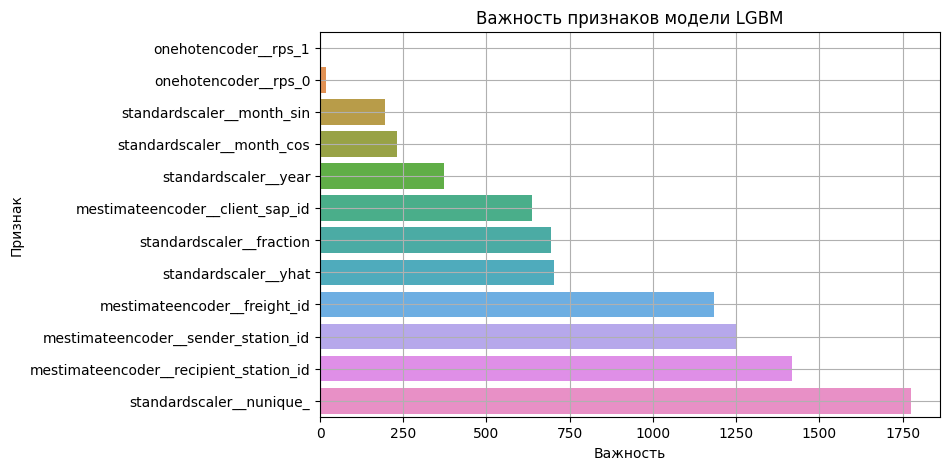

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
temp.sort_values(by='Важность', inplace=True)
sns.barplot(x=temp['Важность'], y=temp.index)
ax.set_xlabel('Важность')
ax.set_ylabel('Признак')
ax.set_title('Важность признаков модели LGBM')
ax.grid();

## Выводы

**Вывод:** В рамках решения задачи были выполнены следующие этапы:
- проведены исследование и предобработка данных,
- выполнена проверка на дубликаты,
- сгенерированы новые признаки,
- обучены несколько моделей,
- по результатам кросс-валидации в качестве основной выбрана модель LightGBM со следующими гиперпараметрами: learning_rate = 0.07, num_leaves = 95, max_depth = 7, random_state = 42;
- выведена важность признаков: самыми влияющими оказались: количество уникальных комбинаций, станции отправления и прибытия.